# MiCoGPT v2.0 Pre-training (Z-Score Sorting)

本 Notebook 演示 **Z-Score 排序** 策略下的预训练。
架构与 Baseline (Only Species) 保持一致：
1. **关闭 Value Embeddings**
2. **关闭 Condition Embeddings**
3. **关闭 Cross-Attention**
4. 仅使用 **Species Embeddings** (物种 ID)

**区别在于语料库构建方式**：
- Baseline: 使用相对丰度降序排列，保留所有 OTU (除了全0)。
- Z-Score: 使用 Z-Score 归一化，过滤 z<0 的 OTU，并按 Z-Score 降序排列 (参考旧版 corpus.py)。

In [1]:
import os
import torch
import warnings
import pickle
from argparse import Namespace
from configparser import ConfigParser
from importlib.resources import files

import pandas as pd
from torch.utils.data import Subset

from transformers import (
    Trainer,
    TrainingArguments,
)
from transformers.trainer_callback import EarlyStoppingCallback

from MiCoGPT.utils_vCross.model_vCross import MiCoGPTConfig, MiCoGPTForCausalLM
from MiCoGPT.utils_vCross.collator_vCross import MiCoGPTDataCollator
from MiCoGPT.utils_vCross.corpus_zscore import MiCoGPTCorpusZScore
from MiCoGPT.utils.tools import split_train_val_by_project_stratified

warnings.filterwarnings("ignore")

## 1. 基本参数设置 (Basic Parameters)

In [2]:
args = Namespace(
    # 原始数据路径
    abundance_path="../data/abundance_all_90338.csv",
    phylogeny_path="../MiCoGPT/resources/phylogeny.csv",
    # 参考的 vCross 语料库 (用于获取 Tokenizer 和 Metadata)
    ref_corpus_path="../data/vCross/ResMicroDB_90338_vCross.pkl",
    
    # 输出的新语料库路径
    output_corpus_path="../data/vCross/ResMicroDB_90338_vCross_ZScore.pkl",
    
    # 输出模型路径
    output="../models/pretrain_vCross_zscore",
    log="../logs/pretrain_vCross_zscore",
    prior_npz=None
)
VAL_RATIO = 0.10

## 2. 构建与加载语料库 (Build & Load Corpus)

我们将使用 `MiCoGPTCorpusZScore` 重新构建语料库。

In [3]:
print("Checking if Z-Score corpus exists...")
if os.path.exists(args.output_corpus_path):
    print(f"Loading existing Z-Score corpus from {args.output_corpus_path} ...")
    with open(args.output_corpus_path, "rb") as f:
        corpus = pickle.load(f)
    tokenizer = corpus.tokenizer
else:
    print("Z-Score corpus not found. Building from scratch...")
    # 1. 加载参考语料库以获取 Tokenizer 和 Metadata
    print(f"Loading reference corpus from {args.ref_corpus_path} ...")
    with open(args.ref_corpus_path, "rb") as f:
        ref_corpus = pickle.load(f)
    
    tokenizer = ref_corpus.tokenizer
    metadata = ref_corpus.metadata
    
    # 2. 构建新语料库
    print("Initializing MiCoGPTCorpusZScore...")
    corpus = MiCoGPTCorpusZScore(
        tokenizer=tokenizer,
        data_path=args.abundance_path,
        phylogeny_path=args.phylogeny_path,
        metadata=metadata,
        max_len=512
    )
    
    # 3. 保存
    print(f"Saving Z-Score corpus to {args.output_corpus_path} ...")
    os.makedirs(os.path.dirname(args.output_corpus_path), exist_ok=True)
    with open(args.output_corpus_path, "wb") as f:
        pickle.dump(corpus, f)
    
    # 清理引用以节省内存
    del ref_corpus

# 筛选数据集 (如果需要)
if corpus.metadata is not None and "Split_Group" in corpus.metadata.columns:
    print("Subsetting corpus by Split_Group == 'A'...")
    corpus = corpus.subset_by_metadata(lambda df: df["Split_Group"] == "A")
else:
    print("Using full corpus (no Split_Group found).")

Checking if Z-Score corpus exists...
Z-Score corpus not found. Building from scratch...
Loading reference corpus from ../data/vCross/ResMicroDB_90338_vCross.pkl ...
Initializing MiCoGPTCorpusZScore...
0 samples are dropped for all zeroes
Your data will be normalized with the phylogeny mean and std.
Converting samples to tokens (Z-Score sorting)...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 90338/90338 [00:29<00:00, 3042.77it/s]


Total 90338 samples.
            Max length is 701.
            Average length is 57.525825234120745.
            Min length is 4.
Saving Z-Score corpus to ../data/vCross/ResMicroDB_90338_vCross_ZScore.pkl ...
Subsetting corpus by Split_Group == 'A'...
[subset_by_metadata] Selected 74557 samples out of 90338.


## 3. 构建 Baseline 模型 (Z-Score Version)

In [4]:
cfg = ConfigParser()
cfg.read(files("MiCoGPT")/"resources/config.ini")

gpt2_config_dict = {
    "vocab_size":   tokenizer.vocab_size,
    "n_positions":  cfg.getint("GPT2", "n_positions"),
    "n_embd":       cfg.getint("GPT2", "n_embd"),
    "n_layer":      cfg.getint("GPT2", "n_layer"),
    "n_head":       cfg.getint("GPT2", "n_head"),
    "bos_token_id": tokenizer.bos_token_id,
    "eos_token_id": tokenizer.eos_token_id,
    "pad_token_id": tokenizer.pad_token_id,
}

config = MiCoGPTConfig(
    num_bins=52,          # 保持结构
    condition_vocab_sizes=[], 
    prior_matrix_path=None,
    add_cross_attention=False,
    **gpt2_config_dict
)

model = MiCoGPTForCausalLM(config)
print("Model Built (Z-Score / Only Species)")

Model Built (Z-Score / Only Species)


## 4. 初始化数据整理器 (屏蔽 Value)

使用与 Baseline 相同的策略，屏蔽 `value_ids`，确保仅利用 Z-Score 排序后的物种序列。

In [5]:
class BaselineDataCollator(MiCoGPTDataCollator):
    def __call__(self, examples):
        batch = super().__call__(examples)
        # [Baseline Key] 屏蔽 Value Embedding
        batch["value_ids"] = None 
        return batch

collator = BaselineDataCollator(
    tokenizer=tokenizer,
    max_length=config.n_positions
)

## 5. 划分数据集

In [6]:
if isinstance(corpus, Subset):
    metadata = corpus.dataset.metadata
else:
    metadata = corpus.metadata

if metadata is not None and "Project_ID" in metadata.columns:
    print("Using stratified split by Project_ID...")
    train_dataset, val_dataset = split_train_val_by_project_stratified(
        corpus,
        val_ratio=VAL_RATIO,
        project_col="Project_ID"
    )
else:
    train_dataset, val_dataset = torch.utils.data.random_split(
        corpus, 
        [len(corpus)-int(len(corpus)*VAL_RATIO), int(len(corpus)*VAL_RATIO)], 
        generator=torch.Generator().manual_seed(42)
    )

Using stratified split by Project_ID...
[split] total_samples=74557, target_val~7456
[split] eligible_projects=304, eligible_samples=74367
[split] ineligible_projects=16, ineligible_samples=190
[split] actual_val=7456 (target~7456), train=67101


In [7]:
training_args = TrainingArguments(
    output_dir=f"{args.output}/checkpoints",
    overwrite_output_dir=True,
    num_train_epochs=50,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    learning_rate=1e-3,
    weight_decay=0.01,
    logging_dir=args.log,
    logging_steps=100,
    save_steps=500,
    eval_steps=500,
    evaluation_strategy="steps",
    save_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    dataloader_num_workers=0,
    dataloader_pin_memory=True,
    fp16=torch.cuda.is_available(),
    no_cuda=not torch.cuda.is_available(),
    report_to=["tensorboard"],
)

In [8]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=10)],
)
trainer.train()

Step,Training Loss,Validation Loss
500,4.661300,4.388296
1000,4.435800,4.226632
1500,4.361300,4.093849
2000,4.275000,4.015112
2500,4.205000,3.964685
3000,4.182300,3.908274
3500,4.104500,3.874604
4000,4.040900,3.836823
4500,4.045900,3.809564
5000,4.006500,3.797283


TrainOutput(global_step=42500, training_loss=3.6744824290556064, metrics={'train_runtime': 4856.8057, 'train_samples_per_second': 690.794, 'train_steps_per_second': 21.588, 'total_flos': 2.639740724576256e+16, 'train_loss': 3.6744824290556064, 'epoch': 20.27})

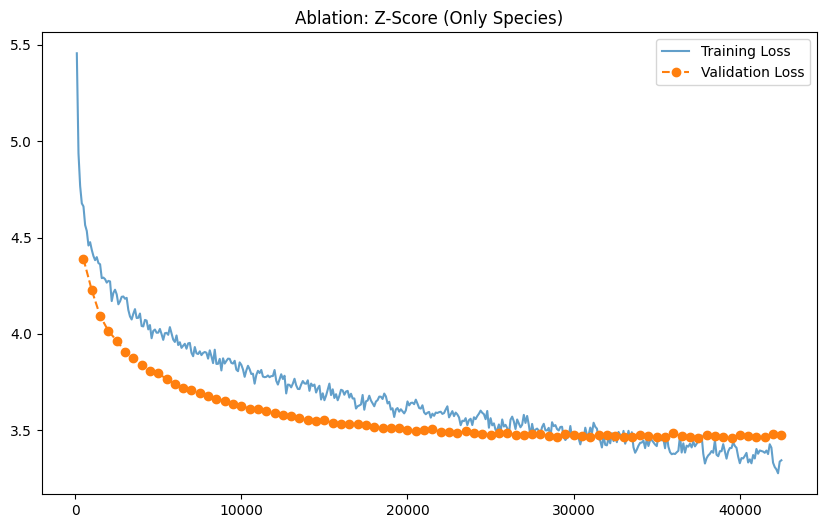

In [11]:
import json
import matplotlib.pyplot as plt
import joblib

trainer.save_model(args.output)

# 尝试保存 tokenizer
try:
    tokenizer.save_pretrained(args.output)
except NotImplementedError:
    print("Warning: tokenizer.save_pretrained() not implemented. Saving via joblib...")
    joblib.dump(tokenizer, f"{args.output}/tokenizer.joblib")

log_history = trainer.state.log_history
with open(f"{args.output}/training_logs.json", "w") as f:
    json.dump(log_history, f, indent=2)

train_steps = [x["step"] for x in log_history if "loss" in x]
train_loss = [x["loss"] for x in log_history if "loss" in x]
eval_steps = [x["step"] for x in log_history if "eval_loss" in x]
eval_loss = [x["eval_loss"] for x in log_history if "eval_loss" in x]

plt.figure(figsize=(10, 6))
if train_steps: plt.plot(train_steps, train_loss, label="Training Loss", alpha=0.7)
if eval_steps: plt.plot(eval_steps, eval_loss, label="Validation Loss", marker="o", linestyle="--")
plt.title("Ablation: Z-Score (Only Species)")
plt.legend()
plt.savefig(f"{args.output}/loss_curve.png")
plt.show()

In [12]:
# 1. 保存模型
trainer.save_model(args.output)

# [Patch] Tokenizer 保存补丁
# 尝试使用标准 save_pretrained，如果报错(NotImplementedError)，则使用 joblib 备份
try:
    corpus.tokenizer.save_pretrained(args.output)
    print(f"Tokenizer saved to {args.output} via save_pretrained")
except NotImplementedError:
    import joblib
    print("Warning: Tokenizer.save_pretrained not implemented. Saving tokenizer object via joblib instead.")
    joblib.dump(corpus.tokenizer, f"{args.output}/tokenizer.joblib")
except Exception as e:
    # 兜底：任何其他错误也尝试用 joblib 救一下
    import joblib
    print(f"Warning: Failed to save tokenizer via save_pretrained ({e}). Saving via joblib.")
    joblib.dump(corpus.tokenizer, f"{args.output}/tokenizer.joblib")

# 保存 Label Encoder (关键)
import joblib
joblib.dump(le, f"{args.output}/label_encoder.joblib")
print(f"Model and LabelEncoder saved to {args.output}")

# 2. 导出日志
log_history = trainer.state.log_history
import json
with open(f"{args.output}/training_logs.json", "w") as f:
    json.dump(log_history, f, indent=2)

# 3. 绘制曲线
train_steps = [x["step"] for x in log_history if "loss" in x]
train_loss = [x["loss"] for x in log_history if "loss" in x]
eval_steps = [x["step"] for x in log_history if "eval_loss" in x]
eval_loss = [x["eval_loss"] for x in log_history if "eval_loss" in x]
eval_f1 = [x["eval_f1"] for x in log_history if "eval_f1" in x]

plt.figure(figsize=(12, 5))

# Loss 曲线
plt.subplot(1, 2, 1)
if train_steps: plt.plot(train_steps, train_loss, label="Train Loss", alpha=0.6)
if eval_steps: plt.plot(eval_steps, eval_loss, label="Val Loss", marker="o")
plt.title("Loss Curve")
plt.legend()

# F1 曲线
plt.subplot(1, 2, 2)
if eval_steps and eval_f1: 
    plt.plot(eval_steps, eval_f1, label="Val F1", color="orange", marker="s")
plt.title("F1 Score Curve")
plt.legend()

plt.savefig(f"{args.output}/training_curve.png")
plt.show()

AttributeError: 'Subset' object has no attribute 'tokenizer'